Imports

In [1]:
import glob
import mediapy as media
import cv2
import random
import mediapy as media
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Util

In [2]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

img_path = natural_sort((glob.glob("TrainingSet/*.jpg")))
anots_path = natural_sort((glob.glob("TrainingSet/*.json")))

print("Total image files:",len(img_path))
print("Total annotations tree:",len(anots_path))

Total image files: 120
Total annotations tree: 120


* There's 120 images of wally
* Based on manual inspections, the images have different shapes
* The wally on the images are the same

# Morphological and Sampling Evaluation


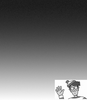
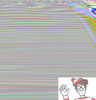
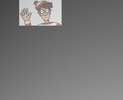
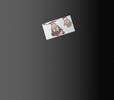
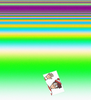

In [3]:
total_samples = 5

img_idx = [random.randint(0, len(img_path)-1) for i in range(total_samples)]

wally_imgs = {}

for idx in img_idx: wally_imgs.update({'wally:'+str(idx)+" \n\r Shape: "+str(cv2.imread(img_path[idx]).shape):media.read_image(img_path[idx])})
    
media.show_images(wally_imgs, vmin=0.0, vmax=1.0, border=True, height=100)

* Image in different shape, need some post-processing on the output
* Images on RGB

# Getting anotations and samples

In [4]:
import json

annot_data = open(anots_path[0],)
data = json.load(annot_data)
data

{'version': '3.21.1',
 'flags': {},
 'lineColor': [0, 255, 0, 128],
 'fillColor': [255, 0, 0, 128],
 'imagePath': 'wally_000.jpg',
 'imageData': None,
 'imageHeight': 730,
 'imageWidth': 1000,
 'shapes': [{'line_color': None,
   'fill_color': None,
   'shape_type': 'polygon',
   'label': 'document',
   'flags': {},
   'points': [[682, 467], [517, 466], [432, 683], [591, 683]]}]}

* The annotation generated a polygon associated
* The polygon get at least four points
* The annotation also get the file name

# Generating mask for data sampling

In [5]:
def invert_points(points):
    
    output = []
    
    for point in points:
        
        output.append([point[1],point[0]])
        
    return np.asarray(output).astype(int)

Img shape: (872, 1000, 3)
Mask shape:( 872 , 1000 )



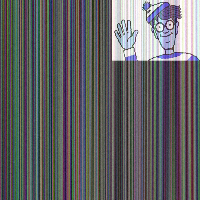


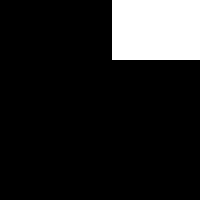

In [6]:
idx = random.randint(0, len(img_path)-1)

#Load annotation
annot_data = open(anots_path[idx],)
data = json.load(annot_data)

#Get only points
points =     np.asarray(data['shapes'][0]['points'])
inv_points = np.asarray(invert_points(points))

#Load image
img  = cv2.imread(img_path[idx])
mask = np.zeros(img.shape)

#Metadata
print("Img shape:",img.shape)
print("Mask shape:(",data['imageHeight'],',',data['imageWidth'],')')


#Drawn polygons
mask = cv2.fillPoly(mask, pts = [points], color=(255,255,255))

#Resinzing for better view
img = cv2.resize(img,(200,200))
mask = cv2.resize(mask,(200,200))

#Showing sample
media.show_image(img,title='Image sample')
media.show_image(mask,title='Mask sample')

* After some manual inspections, some images were wrong annotated, with only three points
* We will discard those type of images

# Data validation

In [7]:
#Filtering ONLY images with four points at least
filteres_images = []
filtered_annots = []
discarded_idx   = []

#Getting each annotated file
for idx, annot_path in enumerate(anots_path):
    
    #Load data
    annot_data = open(anots_path[idx],)
    data = json.load(annot_data)
    
    #Getting points
    points = np.asarray(data['shapes'][0]['points'])
    
    #Saving only valid points
    if(len(points)>=4):
        
        filteres_images.append(img_path[idx])
        filtered_annots.append(anots_path[idx])
        
    else:
        
        discarded_idx.append(idx)
        
#Final file
print('Initial images size',len(img_path),'after filtering',len(filteres_images))
print(len(img_path)-len(filteres_images),'were discarded')

Initial images size 120 after filtering 113
7 were discarded


* In this initial approach, we removed the images with misspaced annotations
* Since only seven images presented this type of error, it was chosen to generate new annotations

### Validate rest of images

In [8]:
idx = random.randint(0, len(img_path)-1)

for idx in range(len(filtered_annots)):

    #Load annotation
    annot_data = open(filtered_annots[idx],)
    data = json.load(annot_data)

    #Get only points
    points =     np.asarray(data['shapes'][0]['points'])
    inv_points = np.asarray(invert_points(points))

    #Load image
    img  = cv2.imread(filteres_images[idx])
    mask = np.zeros(img.shape)

    #Drawn polygons
    mask = cv2.fillPoly(mask, pts = [points], color=(255,255,255))

    #Resinzing for better view
    img = cv2.resize(img,(200,200))
    mask = cv2.resize(mask,(200,200))
    
    output = np.hstack((img,mask))
    cv2.imwrite('evaluation/'+str(idx)+'.png',output)

* In this step was generated all the image from the training to validate if the annotation still correct
* In this step, no invalid annotation was founded
* Generate images are on the evaluation folder

Fixing images

* Only seven images from the original dataset were annotated wrongly, was decide to fix the annotation
* The tool labelme was used
* Was chosen to keep the file image in another folder
* The fixed images are presented on the fixed_training folder

In [9]:
#Index of the "discarded" images
discarded_idx

[5, 6, 38, 56, 62, 82, 113]

In [10]:
#Copying the images to another folder to fix annotations
fix_path = 'fixed_training'

for idx in discarded_idx:
    
    img_fix = cv2.imread(img_path[idx])
    cv2.imwrite(fix_path+'/'+img_path[idx].split('/')[-1],img_fix)

In this step was annotated images manually

In [11]:
fixed_path = natural_sort((glob.glob("fixed_training/*.jpg")))
fixed_annot = natural_sort((glob.glob("fixed_training/*.json")))

Sampling the images

Img shape: (929, 1000, 3)
Mask shape:( 929 , 1000 )



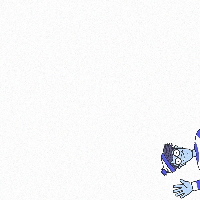


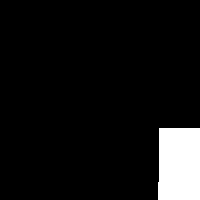

In [12]:
idx = random.randint(0, len(fixed_path)-1)

#Load annotation
annot_data = open(fixed_annot[idx],)
data = json.load(annot_data)

#Get only points
points =     np.asarray(data['shapes'][0]['points']).astype(int)
inv_points = np.asarray(invert_points(points))

#Load image
img  = cv2.imread(fixed_path[idx])
mask = np.zeros(img.shape)

#Metadata
print("Img shape:",img.shape)
print("Mask shape:(",data['imageHeight'],',',data['imageWidth'],')')

#Drawn polygons
mask = cv2.fillPoly(mask, pts = [points], color=(255,255,255))

#Resinzing for better view
img = cv2.resize(img,(200,200))
mask = cv2.resize(mask,(200,200))

#Showing sample
media.show_image(img,title='Image sample')
media.show_image(mask,title='Mask sample')

* Just a simple step to join the original images with the fixed ones

In [13]:
#Joining the paths
joined_imgs   = fixed_path  + filteres_images
joined_annots = fixed_annot + filtered_annots

print("Total image files:",len(joined_imgs))
print("Total annotations:",len(joined_annots))

Total image files: 120
Total annotations: 120


Extracting points to an array

In [14]:
arr_points = []

#Iterate over paths
for json_path in joined_annots:
    
    #Load annotation
    annot_data = open(json_path,)
    data = json.load(annot_data)

    #Get only points
    points = np.asarray(data['shapes'][0]['points']).astype(int)

    arr_points.append(points)

arr_points = np.asarray(arr_points)
arr_points.shape

(120, 4, 2)

* In this step, the list type was converter to a NumPy array

Img shape: (858, 1000, 3)
Mask shape:( 1000 , 1000 )



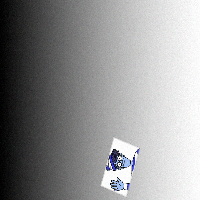


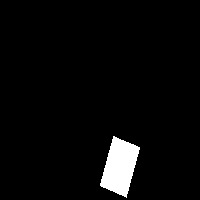

In [15]:
idx = 94//2

#Get only points
points =     arr_points[idx]

#Load image
img  = cv2.imread(joined_imgs[idx])
mask = np.zeros(img.shape)

#Metadata
print("Img shape:",img.shape)
print("Mask shape:(",data['imageHeight'],',',data['imageWidth'],')')

#Drawn polygons
mask = cv2.fillPoly(mask, pts = [points], color=(255,255,255))

#Resinzing for better view
img = cv2.resize(img,(200,200))
mask = cv2.resize(mask,(200,200))

#Showing sample
media.show_image(img,title='Image sample')
media.show_image(mask,title='Mask sample')

* Validation and sampling for the NumPy array conversion

# Segmentation Approach

* Since polygons are handled, the approach based on segmentation can fit the purpose
* Some new images will be generated by data augmentation in the process
* We need to generate a loader or generate the masks 

## Model

In [16]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers.normalization import BatchNormalization
import numpy as np

input_img = Input(shape=(480, 640, 3)) 

x = Conv2D(128, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, x)
autoencoder.summary()

Using TensorFlow backend.
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marrondantas/anaconda3/envs/kerasenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 480, 640, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 240, 320, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 320, 64)      73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 120, 160, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 160, 32)      18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 80, 32)        0         
__________

* Proposed model, based on a FullyConnected
* A model such as UNet could be used, but since we have few images, maybe the training can be at some level, hard
* A detection object such as Yolo, could be used. With a few images, we maybe could get a decent result, but the pot-processing. The bounding boxes could be problematic since we are targetting the centroid of the image 
* This model is resumed and have a lot fewer parameters
* The targeting size of the image was chosen to 640x480x3 and the output a mask, with 640x480x1


## Data agumentation

In [17]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        iaa.SomeOf((1, 5),
            [
                iaa.Fliplr(0.5),
                
                iaa.Flipud(0.2),
                
                iaa.AddToHueAndSaturation((-20, 20)),
                
                iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(0, 255)
                ),
                
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, 
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
                    rotate=(-90, 90), 
                ),
                
            ])])

* Data augmentation pipeline
* On the data augmentation we used, horizontal flip, vertical flip, Hue additional and saturation, crop, scale change, and rotation

In [18]:
import imgaug as ia
import imgaug.augmenters as iaa
from tqdm.notebook import tqdm

total_samples = 120
path_aug_data = 'aug_data'

aug_per_image = total_samples//len(joined_imgs)

aug_paths  = []
aug_points = []

#Verify if the generate points are valid
def valid_points(img_shape, points):
    
    valid = None
    
    for point in points:
        
        if (point[0]>=0 and point[0]<img_shape[0] and point[1]>=0 and point[1]<img_shape[1]):
            
            valid = True
            
        else:
            
            return False
            
    return valid
    

for idx in tqdm(range(len(joined_imgs))):
    
    #Load initial image
    img = cv2.imread(joined_imgs[idx])
    points = arr_points[idx]

    #Aug image
    for i in tqdm(range(aug_per_image)):
        
        while True:
        
            images_aug, points_aug = seq(images=[img], keypoints=[points])

            raw_path = joined_imgs[idx].split('/')[-1].replace('.jpg',"_"+str(i)+".jpg")
            to_save = path_aug_data+'/'+raw_path

            if valid_points(img.shape, points_aug[0]):
                                
                cv2.imwrite(to_save,images_aug[0])
                aug_paths.append(to_save)
                aug_points.append(points_aug[0])
                break
                
            else:
                
                continue
    

Some details:
* We generate approximately 4K images
* From each original image, we generate 33 images
* We need to validate the augmentation to ensure that the wally was fully contained in the image
* In the submission, we generate only 120, as a sample of the 4k generated images
* The data saved on the aug_data

Img shape: (1000, 805, 3)



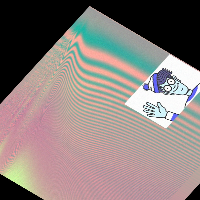


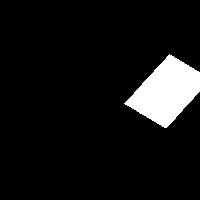

In [19]:
idx_aug = 100

#Get only points
points = aug_points[idx_aug]

#Load image
img  = cv2.imread(aug_paths[idx_aug])
mask = np.zeros(img.shape)

#Metadata
print("Img shape:",img.shape)

#Drawn polygons
mask = cv2.fillPoly(mask, pts = [points], color=(255,255,255))

#Resizing for a better view
img = cv2.resize(img,(200,200))
mask = cv2.resize(mask,(200,200))

#Showing sample
media.show_image(img,title='Image sample')
media.show_image(mask,title='Mask sample')

* Sample of the generated image

Join Data

In [20]:
full_path   = joined_imgs + aug_paths
full_points = np.vstack((arr_points,np.asarray(aug_points)))
len(full_path),full_points.shape

(240, (240, 4, 2))

* Joining the full data, the original data, plus the augmentation data

# Data Loader

In [21]:
#Custom function to get an image in the desired shape
def get_reshaped_data(img,points,output_shape=(640,480)):
    
    empty_mask = np.zeros(img.shape)
    mask = cv2.fillPoly(empty_mask, pts = [points], color=(255,255,255))
    
    mask = mask[:,:,0]
    
    out_img = cv2.resize(img, output_shape)
    mask    = cv2.resize(mask, output_shape)
    
    mask[mask<127]  =0
    mask[mask>=127] = 1

    mask = np.reshape(mask,(mask.shape[0],mask.shape[1],1))
    
    out_img = out_img/255.0

    return out_img, mask

#Custom loader, with shape option
def custom_loader(img_paths, points, size_batch=5,output_shape=(640,480)):
    
    begin = 0
    end   = size_batch
    
    while True:
        
        partial_paths = img_paths[begin:end]
        partial_points = points[begin:end]
        
        output_imgs   = []
        output_points = []
        
        for idx, path in enumerate(partial_paths):
            
            img = cv2.imread(path)
            
            img, mask = get_reshaped_data(img,partial_points[idx],output_shape=(640,480)) 

            output_imgs.append(img)
            output_points.append(mask)
            
        yield np.asarray(output_imgs), np.asarray(output_points)
        
        begin = end
        end += size_batch

        if (end>=len(img_paths)):
            
            begin=0
            end = size_batch
        
train_loader = custom_loader(full_path, full_points, size_batch=5,output_shape=(640,480))

* Was generate a custom loader from the images
* The loader receiver the points, and the path of the image
* The loader also generates the masks for prediction
* Was used a custom loader to speed up the process, was avoided the loader provider by Keras, due to nuances of the dataset generated
* Was added the option of the image reshape, since the image variate in size


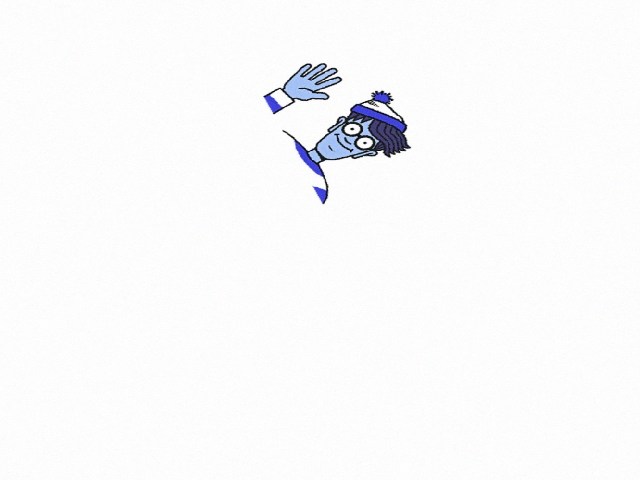


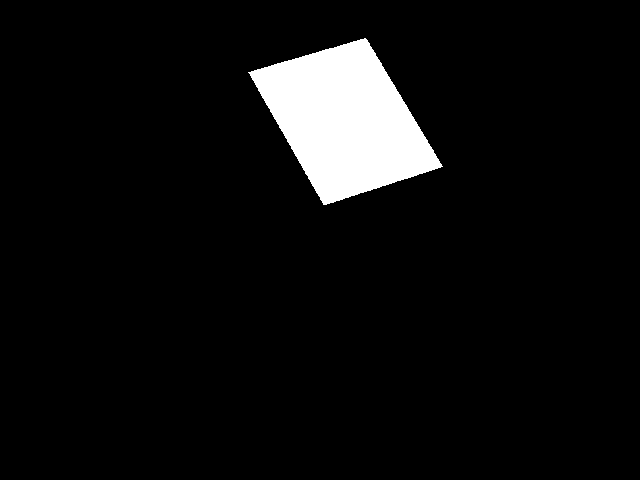

In [22]:
x, y = next(train_loader)

x.shape, y.shape

media.show_image(x[1],title='Image sample')
media.show_image(y[1]*255,title='Mask sample')

* Simple sample of the loader

# Training the model

In [ ]:
from keras.callbacks import ModelCheckpoint

autoencoder.compile(
    'Adam',
    loss="binary_crossentropy",
    metrics=['MSE'],
)

checkpoint_loss_ = ModelCheckpoint('single_loss_best.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint_loss_]

autoencoder.fit_generator(train_loader,steps_per_epoch=len(full_path) // 5,epochs=30, callbacks=callbacks_list)

Some details:
* In this step, we used an Adam optimizer
* The binary cross-entropy seem a good fit since in-depth we are handling with a binary classification (foreground and background)
* We save the best model, with the minimal loss
* No cross-validation was performed, based on the size of the dataset
* This step was performed on the Collab for hardware limitation
* The model could be trained longer and even get a better result, but the platform limited the training process
* The best weight as saved in the root folder as "singe_loss_best.h5"
* Results: loss: 0.0134 - MSE: 0.0040
* Link Collab: https://drive.google.com/file/d/1ZP01a4LbOW5ibXqYvaDGC7_RuKmN216X/view?usp=sharing

Predict Sample - Training


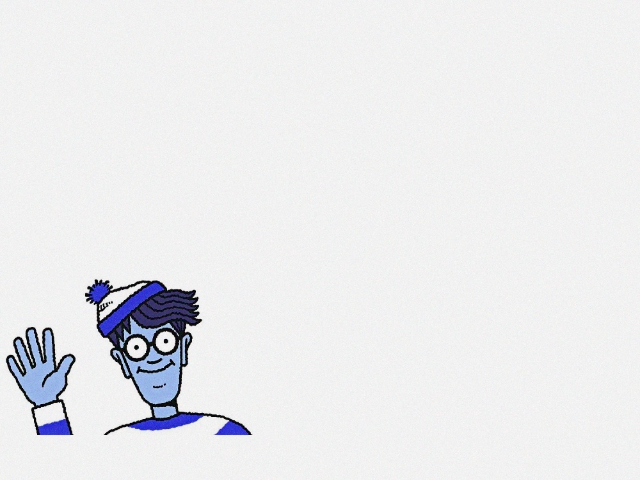


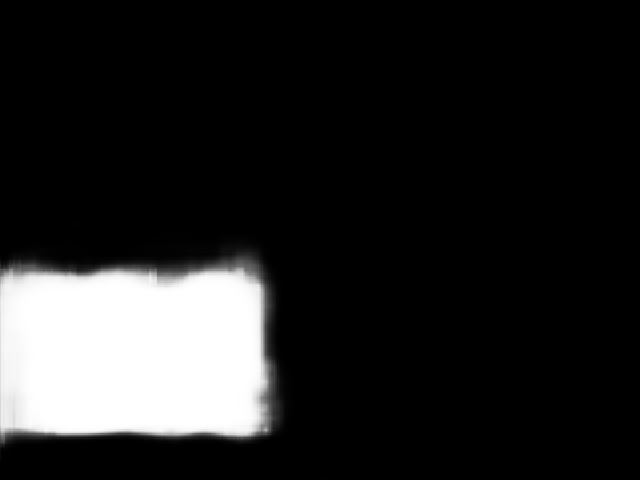

In [23]:
autoencoder.load_weights('singe_loss_best.h5')

train_loader = custom_loader(full_path, full_points, size_batch=5,output_shape=(640,480))

x,y = next(train_loader)

predictions = autoencoder.predict(x)

x_ = predictions[0]

media.show_image(x[0],title='Image sample')
media.show_image(x_,title='Image sample')

* Sample prediction on the training
* As observed, the CNN seems to get the wally
* Overall, we get a good shape
* Not only the wally was segmented, but the area around

Evaluating Sample - Test

In [24]:
img_path = natural_sort((glob.glob("TestSet/*.jpg")))

print("Total image files:",len(img_path))

Total image files: 30


In [27]:
#Get the centroid based on the contour information
def get_centroid(cnt):

    upper_x = None
    upper_y = None
    down_x = None
    down_y = None

    flatten_cnt = cnt.flatten()
    flatten_cnt = np.reshape(flatten_cnt,(len(cnt),2))

    x_axis = flatten_cnt[:,0]
    y_axis = flatten_cnt[:,1]

    upper_x, down_x = x_axis.max(), x_axis.min()
    upper_y, down_y = y_axis.max(), y_axis.min()

    centroid_x = int((down_x + upper_x) / 2)
    centroid_y = int((down_y + upper_y) / 2)
    
    return [centroid_x,centroid_y]

test_output = []

for idx in tqdm(range(len(img_path))):
    
    #Partial path from the list
    partial_path = img_path[idx]
    
    #Predict image
    raw_img = cv2.imread(partial_path)
    
    #raw_shape
    raw_shape = raw_img.shape

    img = cv2.resize(raw_img,(640,480))
    
    new_shape = img.shape
    
    ratio_arr = raw_shape[0]/new_shape[0],raw_shape[1]/new_shape[1]
    
    to_predict = img/255.0
        
    prediction = autoencoder.predict(np.asarray([to_predict]))[0]
    
    prediction[prediction>=0.5]=255
    prediction[prediction<0.5] = 0
    
    prediction = np.reshape(prediction,(480,640))
    
    
    #finding contours
    contours,_=cv2.findContours(prediction.astype(np.uint8), cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)
    
    #Only the biggest area
    idx_biggest = -1
    biggest_area = -1*float('inf')
    
    for idx_cnt, cnt in enumerate(contours):
        
        area = cv2.contourArea(cnt)
        
        if (area>biggest_area):
            
            biggest_area = area
            idx_biggest  = idx_cnt
            
    centroid = get_centroid(contours[idx_biggest])
    centroid[0] = int(centroid[0]*ratio_arr[1])
    centroid[1] = int(centroid[1]*ratio_arr[0])
    
    test_output.append([partial_path,centroid[0],centroid[1]])
        
    prediction = cv2.cvtColor(prediction,cv2.COLOR_GRAY2RGB)
    prediction = cv2.resize(prediction,(raw_shape[1],raw_shape[0]))
    
    raw_img = cv2.circle(raw_img, (centroid[0],centroid[1]), radius=15, color=(0, 255, 0), thickness=-1)
    
    output = np.hstack((raw_img,prediction))

    path_save = 'test_evaluation/'+str(idx)+'.png'
    
    cv2.imwrite(path_save,output) 

  0%|          | 0/30 [00:00<?, ?it/s]

Some details:
* In this step, we validate the solution on the test set
* As required for the test was also needed to extract the centroid
* First from the image was obtained the prediction. From the prediction, we generate a mask based on a simple threshold. From the mask, we extract the contours, and for the centroid generation, we get the maximum and minimum dimensions for the contoured detected and extract the centroid
* Since the output can generate some artifacts,  the contour detection can detect multiple zones and zone with no wally. The approach to avoid false detection was to consider the contour with the maximum area, targetting the wally area
* centroid_x = (max_x+min_x)/2 ; centroid_y = (max_y+min_y)/2
* The ratio was kept, even we detection on an image with 640x480, we reverse the centroids dimensions to fit the original image
* The prediction is on the test_evaluation folder

Sample of the centroid acquired


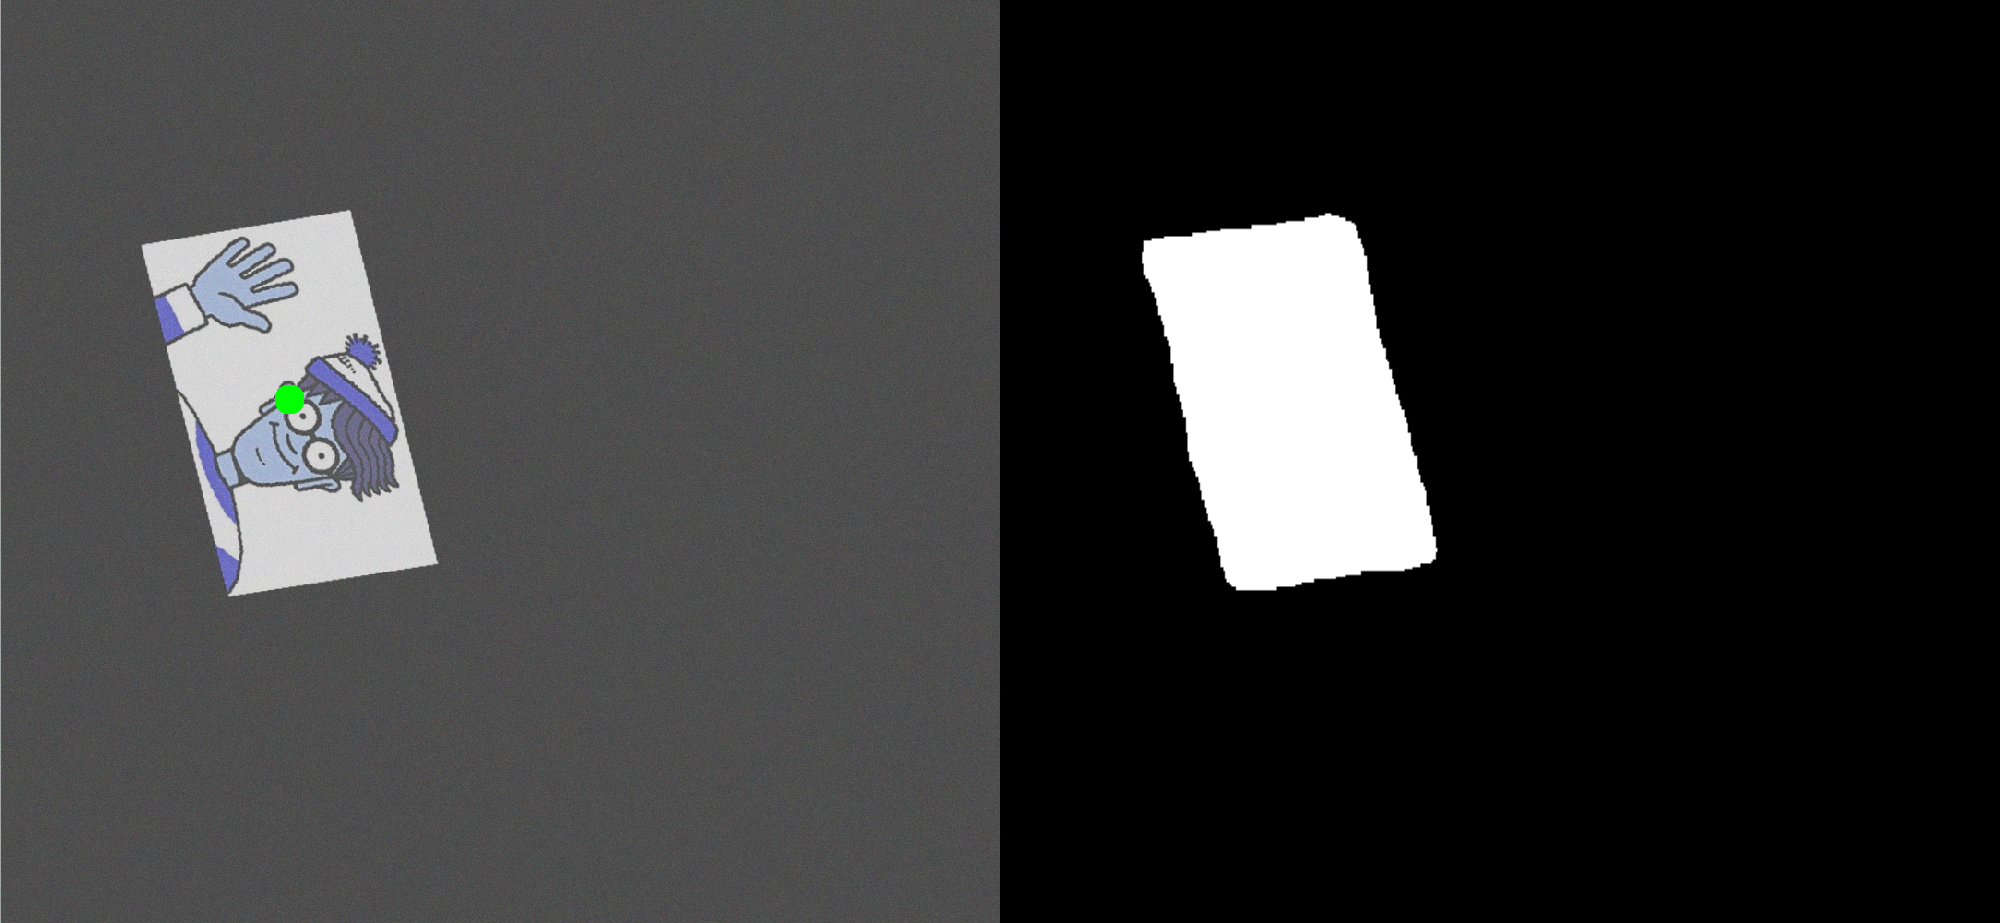

In [29]:
media.show_image(cv2.imread('test_evaluation/15.png'),title='')


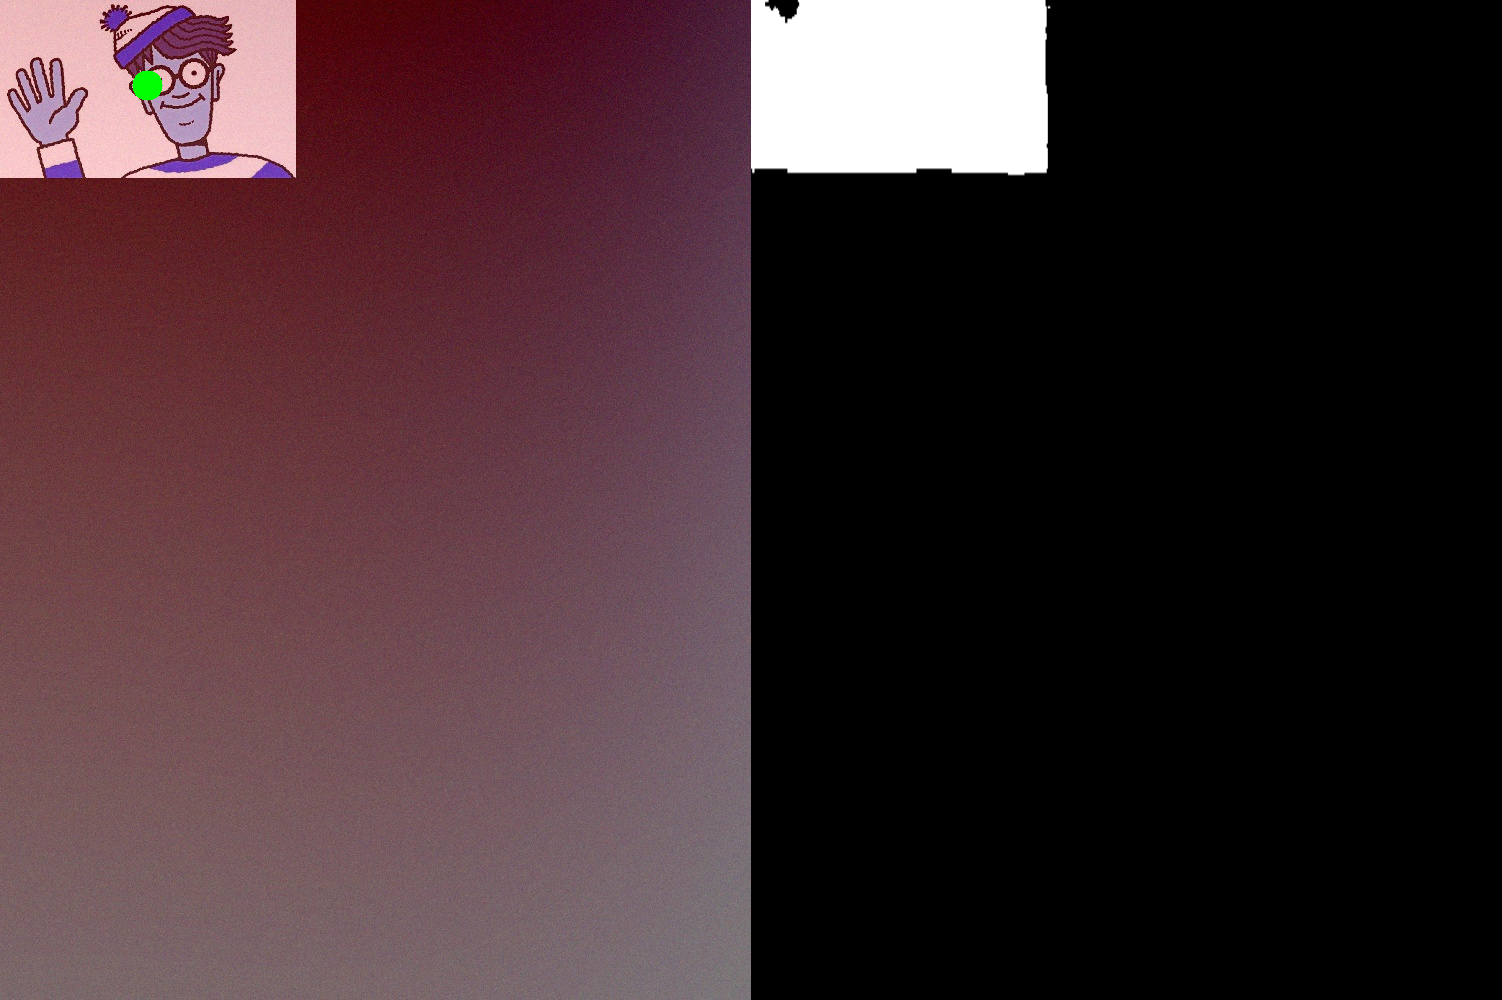

In [30]:
media.show_image(cv2.imread('test_evaluation/25.png'),title='')

Generating the desired test output

In [28]:
import pandas as pd

df = pd.DataFrame(np.asarray(test_output))
df.to_csv('test_pred.csv',header=False, index=False)
df

0    1    2
0   TestSet/wally_004.jpg  807  856
1   TestSet/wally_005.jpg  165  408
2   TestSet/wally_010.jpg  576  503
3   TestSet/wally_016.jpg  412  462
4   TestSet/wally_021.jpg  809  692
5   TestSet/wally_025.jpg  725  252
6   TestSet/wally_041.jpg  118  542
7   TestSet/wally_051.jpg  278  400
8   TestSet/wally_057.jpg  360  359
9   TestSet/wally_058.jpg  401  279
10  TestSet/wally_062.jpg  150  206
11  TestSet/wally_063.jpg  307  137
12  TestSet/wally_070.jpg  321  171
13  TestSet/wally_071.jpg  491  243
14  TestSet/wally_076.jpg  732  166
15  TestSet/wally_078.jpg  289  399
16  TestSet/wally_079.jpg  756  713
17  TestSet/wally_084.jpg  399  481
18  TestSet/wally_103.jpg  102  172
19  TestSet/wally_105.jpg  642  337
20  TestSet/wally_109.jpg  417  793
21  TestSet/wally_111.jpg  508  225
22  TestSet/wally_112.jpg  105  827
23  TestSet/wally_114.jpg  754  568
24  TestSet/wally_118.jpg  230  381
25  TestSet/wally_128.jpg  147   85
26  TestSet/wally_130.jpg  464  294
27  TestSet/wally_139.jpg  543  500
28  TestSet/wally_145.jpg  660  475
29  TestSet/wally_149.jpg  602  247

* Saving the prediction solution to CSV as request on the test